In [1]:
import sys
import h5py
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pathlib import Path
from mne import read_epochs, viz, combine_evoked, __version__
from mne import time_frequency 
from util import get_directories, get_files, make_directory, check_many
from autoreject import AutoReject, Ransac, get_rejection_threshold, read_auto_reject
from superlet import superlet, scale_from_period
from tqdm.notebook import tqdm

In [14]:
/home/mszul/datasets/act_mis/outputs/basic/0001_psd_topomap.png

'1.6.0'

In [4]:
processed_path = Path("/home/mszul/datasets/act_mis/MEG/processed")
beh_path = Path("/home/mszul/datasets/act_mis/BEH")
fif_paths = get_files(processed_path, "*.fif", strings=["autoreject", "observation", "-epo.fif"])
h5_paths = get_files(processed_path, "*.h5", strings=["autoreject", "observation", "-epo.h5"])
fif_paths.sort()
h5_paths.sort()

In [5]:
index = 0

fif_path = fif_paths[index]
og_file = fif_path.parent.joinpath(fif_path.name[11:])
h5_path = h5_paths[index]

_, subj_id, _, ses, epo_type, _ = fif_path.stem.split("-")
ses_ix = eval(ses)

beh_subj_path = beh_path.joinpath(subj_id)
beh_file = get_files(beh_subj_path, "*.pkl")[ses_ix]
beh = pd.read_pickle(beh_file)
epochs = read_epochs(fif_path, verbose=False).pick("mag")
epochs = epochs.apply_baseline(baseline=[None, 0], verbose=False)
og_epochs = read_epochs(og_file, verbose=False).pick("mag")
og_epochs = og_epochs.apply_baseline(baseline=[None, 0], verbose=False)
ar = read_auto_reject(h5_path)
reject_log = ar.get_reject_log(og_epochs)
rejected_epochs = reject_log.bad_epochs

beh = beh.loc[beh.obs_dir_mod != 0]
beh = beh[~rejected_epochs]

Removing 5 compensators from info because not all compensation channels were picked.


NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
    Using multitaper spectrum estimation with 7 DPSS windows


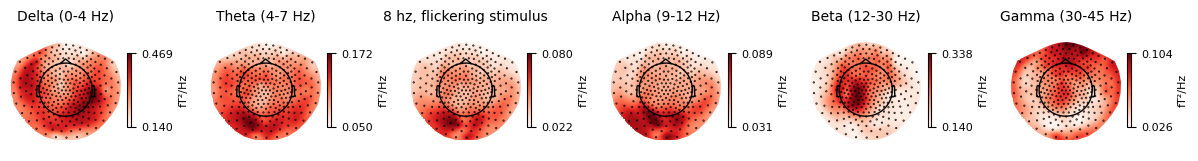

In [6]:
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-7 Hz)': (4, 7), 
         "8 hz, flickering stimulus": (7,9),
         'Alpha (9-12 Hz)': (9, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}
epochs.plot_psd_topomap(bands=bands, normalize=True);

In [7]:
con_incon = combine_evoked(
    [epochs["obs_congr"].average(), epochs["obs_incongr"].average()],
    weights=[1, -1]
)

In [9]:
%matplotlib qt
con_incon.plot_joint(times= [0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8]);

No projector specified for this dataset. Please consider the method self.add_proj.


qt.xkb.compose: failed to create compose table


In [10]:
sfreq = epochs.info["sfreq"]
max_freq = 80
foi = np.linspace(1, max_freq, 120)
scales = scale_from_period(1/foi)

In [11]:
# mean_cond = {}
# epoch_data = epochs.get_data()
# for ch_ix, ch_name in enumerate(epochs.ch_names):
#     trials = epoch_data[:, ch_ix, :]
#     tf_trials = []
#     for trial in tqdm(trials):
#         tf = superlet(
#             trial, sfreq, scales, 40, c_1=4, adaptive=True
#         )
#         tf_trials.append(np.single(np.abs(tf)))
#     tf_trials = np.array(tf_trials)
#     mean_cond[ch_name] = [
#         np.mean(tf_trials[(beh.obs_dir_mod == 1).to_numpy()], axis=0),
#         np.mean(tf_trials[(beh.obs_dir_mod == -1).to_numpy()], axis=0),
#     ]

with open("output_run.pickle", "rb") as file:
    mean_cond = pickle.load(file)

In [12]:
congruent = []
incongruent = []
for ch_name in epochs.ch_names:
    cong, incong = mean_cond[ch_name]
    congruent.append(cong)
    incongruent.append(incong)
congruent = np.array(congruent)
incongruent = np.array(incongruent)

In [16]:
con_spec = time_frequency.AverageTFR(
    epochs.info, congruent, epochs.times, foi,
    nave=1, method="superlet"
)
# con_spec = con_spec.apply_baseline((None, 0), mode="percent")

incon_spec = time_frequency.AverageTFR(
    epochs.info, incongruent, epochs.times, foi,
    nave=1, method="superlet",
)
# incon_spec = incon_spec.apply_baseline((None, 0), mode="percent")

sub_data = con_spec.__sub__(incon_spec)

In [49]:
%matplotlib qt

In [18]:
con_spec.plot_topo(baseline=(None, 0), mode="percent");

Applying baseline correction (mode: percent)


/home/mszul/miniconda3/envs/mne_new/lib/python3.10/site-packages/matplotlib/cbook.py:298: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/home/mszul/miniconda3/envs/mne_new/lib/python3.10/site-packages/matplotlib/cbook.py:298: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
/home/mszul/miniconda3/envs/mne_new/lib/python3.10/site-packages/matplotlib/cbook.py:298: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/home/mszul/miniconda3/envs/mne_new/lib/python3.10/site-packages/matplotlib/cbook.py:298: RuntimeWarning: `mask` is None, not adding contour to the plot ...
  func(*args, **kwargs)
/home/mszul/miniconda3/envs/mne_new/lib/python3.10/site-packages/matplotlib/cbook.py:298: RuntimeWarning: `mask` is None, not masking the plot ...
  func(*args, **kwargs)
/home/mszul/miniconda3/envs/mne_new/lib/python3.10/site-packages/matplotlib/cbook.py:298: RuntimeWarning: `mask` is None, not